# Zeitliche Exploration

In diesem Notebook werden zeitliche Muster der CitiBike-Nutzung sowie zeitliche Strukturen der Unfallmeldungen betrachtet. 
Die Analyse dient dazu, regelmäßige Verhaltensmuster, saisonale Schwankungen und tageszeitliche Unterschiede zu identifizieren. 
Die Erkenntnisse bilden eine Grundlage für spätere Risikomodelle sowie für die Ableitung plausibler Hypothesen im Kontext der Unfallwahrscheinlichkeiten.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from citibike_analysis.utils.paths import FIGURES_DIR
from citibike_analysis.utils.paths import DATA_SPATIAL
from citibike_analysis.utils.paths import DATA_TEMPORAL

# Unterordner für dieses Notebook
FIG_SUBDIR = "02B_temporal_exploration"
figures_path = os.path.join(FIGURES_DIR, FIG_SUBDIR)

# Ordner anlegen, falls nicht vorhanden
os.makedirs(figures_path, exist_ok=True)

## 1. Setup und Laden der Daten

In [5]:
cols_cb = [
    "started_at",
    'ended_at',
    "rideable_type",
    "member_casual",
    "duration_min"
]

# CitiBike-Daten laden
path_cb = os.path.join(DATA_SPATIAL, 'citibike_spatial_granular.parquet')
df_cb = pd.read_parquet(path_cb, columns=cols_cb)

cols_nypd = [
    "crash_datetime",
    "cyclist_involved",
    "bike_involved",
    "ebike_involved",
    "ambiguous",
    "NUMBER OF PERSONS INJURED",
    "NUMBER OF PERSONS KILLED",
    "persons_severe",
    "NUMBER OF CYCLIST INJURED",
    "NUMBER OF CYCLIST KILLED",
    "cyclists_severe",
]

# NYPD-Daten laden
path_nypd = os.path.join(DATA_SPATIAL, 'nypd_spatial_granular.parquet')
df_nypd = pd.read_parquet(path_nypd, columns=cols_nypd)


In [6]:
df_cb.head()

,started_at,ended_at,rideable_type,member_casual,duration_min
0,2023-01-03 23:14:52.325,2023-01-03 23:33:42.737,classic_bike,casual,18.840200
1,2023-01-07 07:57:40.054,2023-01-07 08:01:27.330,electric_bike,casual,3.787933
2,2023-01-09 18:37:44.830,2023-01-09 18:48:56.233,electric_bike,member,11.190050
3,2023-01-05 19:06:15.350,2023-01-05 19:08:33.547,electric_bike,casual,2.303283
4,2023-01-02 20:25:23.300,2023-01-03 10:51:25.164,electric_bike,casual,866.031067


In [7]:
df_nypd.head()

,crash_datetime,cyclist_involved,bike_involved,ebike_involved,ambiguous,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,persons_severe,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,cyclists_severe
0,2023-01-01 05:30:00,False,False,False,False,0,0,0,0,0,0
1,2023-01-01 08:45:00,False,False,False,False,0,0,0,0,0,0
2,2023-01-01 19:00:00,False,False,False,False,1,0,1,0,0,0
3,2023-01-01 16:35:00,False,False,False,False,0,0,0,0,0,0
4,2023-01-01 00:00:00,False,False,False,False,0,0,0,0,0,0


## 2. Temporale Feature-Erweiterung

In diesem Schritt werden zusätzliche zeitbezogene Merkmale erstellt, die für die spätere Analyse der Nutzungs- und Unfallmuster erforderlich sind. 
Die Transformation ergänzt beide Datensätze um konsistente Tages-, Wochen-, Monats- und Saisonmerkmale.

In [8]:
# Funktion zur Erzeugung zeitlicher Merkmale aus einem Datumszeitfeld
def add_temporal_features(df, dt_col):
    df = df.copy()
    
    dt = df[dt_col]

    # Grundlegende Zeitmerkmale (vektorisiert)
    df["date"] = dt.dt.floor("D")
    df["quarter"] = dt.dt.quarter.astype("int8")
    df["month"] = dt.dt.month.astype("int8")
    df["week"] = dt.dt.isocalendar().week.astype("int16")
    df["day"] = dt.dt.day.astype("int8")
    df["hour"] = dt.dt.hour.astype("int8")
    df["weekday"] = dt.dt.weekday.astype("int8")
    df["is_weekend"] = (df["weekday"] >= 5)
    df["is_weekday"] = ~df["is_weekend"]

    # Vektorisierte Saisonzuordnung
    # Season Codes: 0=winter,1=spring,2=summer,3=fall
    month = df["month"].values
    season = np.empty_like(month)

    # Winter: Dezember, Januar, Februar
    winter = (month == 12) | (month <= 2)
    season[winter] = 0

    # Frühling: März bis Mai
    spring = (month >= 3) & (month <= 5)
    season[spring] = 1

    # Sommer: Juni bis August
    summer = (month >= 6) & (month <= 8)
    season[summer] = 2

    # Herbst: September bis November
    fall = (month >= 9) & (month <= 11)
    season[fall] = 3

    # Zuordnung der Saisonbezeichnungen
    season_map = {0: "winter", 1: "spring", 2: "summer", 3: "fall"}
    df["season"] = pd.Categorical([season_map[s] for s in season])

    return df


# Hilfsfunktion zur Formatierung von Minutenangaben auf Achsen
def minutes_to_hhmm(x, pos):
    # <60 -> 'XX min'
    # >=60 -> 'HH:MM'
    x_int = int(x)
    if x_int < 60:
        return f"{x_int} min"
    else:
        h = x_int // 60
        m = x_int % 60
        return f"{h:02d}:{m:02d}"

### 2.1 Transformation CitiBike

In [9]:
# Zeitliche Merkmale für CitiBike-Daten erzeugen
df_cb_temporal = add_temporal_features(df_cb, 'started_at')
df_cb_temporal

,started_at,ended_at,rideable_type,member_casual,duration_min,date,quarter,month,week,day,hour,weekday,is_weekend,is_weekday,season
0,2023-01-03 23:14:52.325,2023-01-03 23:33:42.737,classic_bike,casual,18.840200,2023-01-03,1,1,1,3,23,1,False,True,winter
1,2023-01-07 07:57:40.054,2023-01-07 08:01:27.330,electric_bike,casual,3.787933,2023-01-07,1,1,1,7,7,5,True,False,winter
2,2023-01-09 18:37:44.830,2023-01-09 18:48:56.233,electric_bike,member,11.190050,2023-01-09,1,1,2,9,18,0,False,True,winter
3,2023-01-05 19:06:15.350,2023-01-05 19:08:33.547,electric_bike,casual,2.303283,2023-01-05,1,1,1,5,19,3,False,True,winter
4,2023-01-02 20:25:23.300,2023-01-03 10:51:25.164,electric_bike,casual,866.031067,2023-01-02,1,1,1,2,20,0,False,True,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35000372,2023-12-27 12:41:55.381,2023-12-27 12:51:52.849,electric_bike,member,9.957800,2023-12-27,4,12,52,27,12,2,False,True,winter
35000373,2023-12-30 17:36:53.064,2023-12-30 17:41:48.918,classic_bike,member,4.930900,2023-12-30,4,12,52,30,17,5,True,False,winter
35000374,2023-12-31 23:18:19.106,2023-12-31 23:31:03.529,electric_bike,member,12.740383,2023-12-31,4,12,52,31,23,6,True,False,winter
35000375,2023-12-31 16:58:07.255,2023-12-31 17:05:18.573,electric_bike,member,7.188633,2023-12-31,4,12,52,31,16,6,True,False,winter


In [10]:
df_cb_temporal.dtypes

started_at       datetime64[ns]
ended_at         datetime64[ns]
rideable_type          category
member_casual          category
duration_min            float64
date             datetime64[ns]
quarter                    int8
month                      int8
week                      int16
day                        int8
hour                       int8
weekday                    int8
is_weekend                 bool
is_weekday                 bool
season                 category
dtype: object

### 2.2 Transformation NYPD

In [11]:
# Zeitliche Merkmale für NYPD-Daten erzeugen
df_nypd_temporal = add_temporal_features(df_nypd, "crash_datetime")
df_nypd_temporal

,crash_datetime,cyclist_involved,bike_involved,ebike_involved,ambiguous,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,persons_severe,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,...,date,quarter,month,week,day,hour,weekday,is_weekend,is_weekday,season
0,2023-01-01 05:30:00,False,False,False,False,0,0,0,0,0,...,2023-01-01,1,1,52,1,5,6,True,False,winter
1,2023-01-01 08:45:00,False,False,False,False,0,0,0,0,0,...,2023-01-01,1,1,52,1,8,6,True,False,winter
2,2023-01-01 19:00:00,False,False,False,False,1,0,1,0,0,...,2023-01-01,1,1,52,1,19,6,True,False,winter
3,2023-01-01 16:35:00,False,False,False,False,0,0,0,0,0,...,2023-01-01,1,1,52,1,16,6,True,False,winter
4,2023-01-01 00:00:00,False,False,False,False,0,0,0,0,0,...,2023-01-01,1,1,52,1,0,6,True,False,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61589,2023-12-31 05:30:00,True,True,False,False,1,0,1,1,0,...,2023-12-31,4,12,52,31,5,6,True,False,winter
61590,2023-12-31 20:00:00,False,False,False,False,0,0,0,0,0,...,2023-12-31,4,12,52,31,20,6,True,False,winter
61591,2023-12-31 18:00:00,True,True,False,False,1,0,1,1,0,...,2023-12-31,4,12,52,31,18,6,True,False,winter
61592,2023-12-31 15:30:00,False,False,False,False,0,0,0,0,0,...,2023-12-31,4,12,52,31,15,6,True,False,winter


## 3. Qualitätsprüfungen

In diesem Abschnitt werden grundlegende zeitbezogene Qualitätsprüfungen durchgeführt. 
Ziel ist es, potenziell fehlerhafte Fahrten zu identifizieren und eine bereinigte Grundlage für die anschließende Analyse der zeitlichen Muster zu schaffen.

### 3.1 Fahrten über Tageswechsel

In [13]:
# Berechnung der Tagesgrenzen zur Identifikation von Fahrten, die über Mitternacht hinausgehen
start_day = df_cb["started_at"].dt.normalize()   # 00:00:00 desselben Tages
end_day   = df_cb["ended_at"].dt.normalize()

# Kennzeichnung von Fahrten, deren Start- und Endtag unterschiedlich sind
mask_cross_day = start_day != end_day

# Anzahl solcher Fahrten ermitteln
cross_days = mask_cross_day.sum()
total = len(df_cb)

print("Anzahl Fahrten gesamt:", total)
print("Fahrten über Tageswechsel:", cross_days)
print("Anteil:", f"{cross_days / total:.4%}")

Anzahl Fahrten gesamt: 35000377
Fahrten über Tageswechsel: 157705
Anteil: 0.4506%


### 3.2 Dauerplausibilität

In der Datenvorverarbeitung wurden bereits alle Fahrten mit einer Dauer von mehr als 24 Stunden entfernt, da diese eindeutig fehlerhafte Systemeinträge sind.
Bevor die zeitlichen Muster analysiert werden, erfolgt eine erneute Prüfung der Fahrtdauern. 
Ziel ist eine robuste Obergrenze plausibler Fahrten, um fehlerhafte oder technisch bedingte Extremwerte auszuschließen.
Dazu werden zunächst die oberen Quantile der Spalte `duration_min` betrachtet.

In [14]:
# Obere Quantile der Fahrtdauer zur Einschätzung extremer Werte
print("Obere Quantile der Fahrtdauer (in Minuten):")
df_cb_temporal["duration_min"].quantile([0.99, 0.995, 0.999, 0.9995])

Obere Quantile der Fahrtdauer (in Minuten):


0.9900     66.501316
0.9950     89.765168
0.9990    264.477733
0.9995    579.220606
Name: duration_min, dtype: float64

In [15]:
# Festlegung einer Obergrenze für plausible Fahrtdauern (6 Stunden = 360 Minuten)
max_duration = 360  

# Kennzeichnung plausibler Fahrten
mask_plausible = df_cb_temporal["duration_min"] <= max_duration

# Anzahl und Anteil ausgeschlossener Fahrten
outliers = (~mask_plausible).sum()
ratio = outliers / len(df_cb_temporal)

print(f"Ausgeschlossene Fahrten: {outliers:,} ({ratio:.4%})")

# Bereinigung des Datensatzes
df_cb_temporal = df_cb_temporal[mask_plausible]

Ausgeschlossene Fahrten: 27,179 (0.0777%)


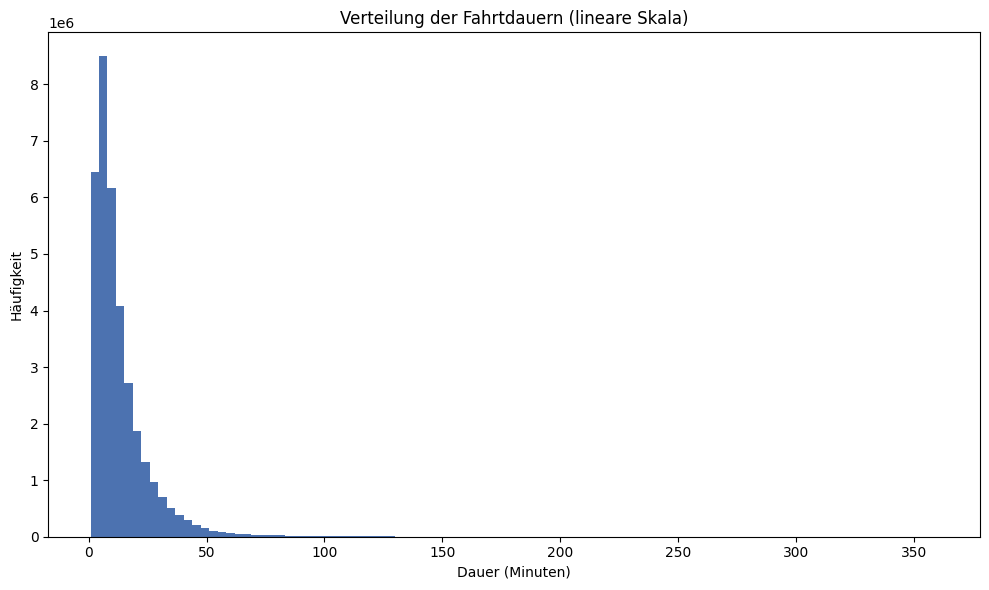

In [18]:
# Histogramm der bereinigten Fahrtdauern zur qualitativen Kontrolle
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_cb_temporal["duration_min"], bins=100, color="#4C72B0")

ax.set_title("Verteilung der Fahrtdauern (lineare Skala)")
ax.set_xlabel("Dauer (Minuten)")
ax.set_ylabel("Häufigkeit")

plt.tight_layout()
figure_path = os.path.join(figures_path, "duration_distribution_linear.png")
plt.savefig(figure_path, dpi=300)
plt.show()

## 4. Zeitliche Muster CitiBike

In diesem Abschnitt werden zentrale zeitliche Nutzungsmuster der CitiBike-Fahrten analysiert. 
Betrachtet werden Tages-, Wochen-, Monats- und Saisonstrukturen sowie stündliche Muster. 
Ziel ist es, typische Verhaltensverläufe und wiederkehrende zeitliche Spitzen zu identifizieren.

### 4.1 Tagesmuster

#### 4.1.1 Anzahl Fahrten pro Tag

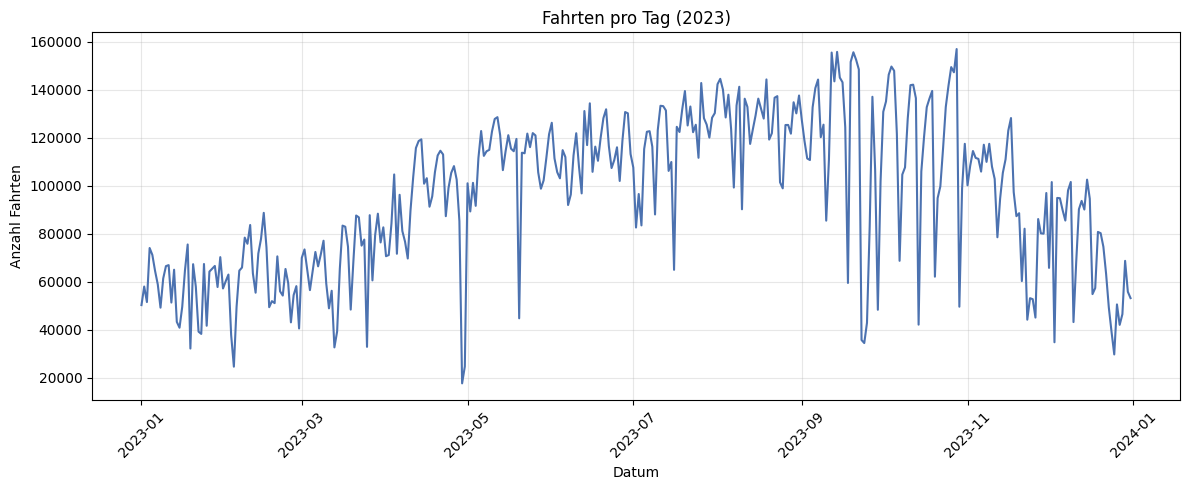

In [39]:
# Aggregation der täglichen Fahrten
daily_rides = (
    df_cb_temporal
    .groupby("date", observed=True)
    .size()
    .sort_index()
)

# Liniendiagramm der täglichen Fahrten
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(
    daily_rides.index.to_numpy(),   # zwingt Matplotlib in 1D
    daily_rides.values,
    color="#4C72B0"
)

ax.set_title("Fahrten pro Tag (2023)")
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl Fahrten")
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()

fig_path = os.path.join(figures_path, "daily_rides_timeseries.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 4.1.2 7-Tage-gleitender Durchschnitt

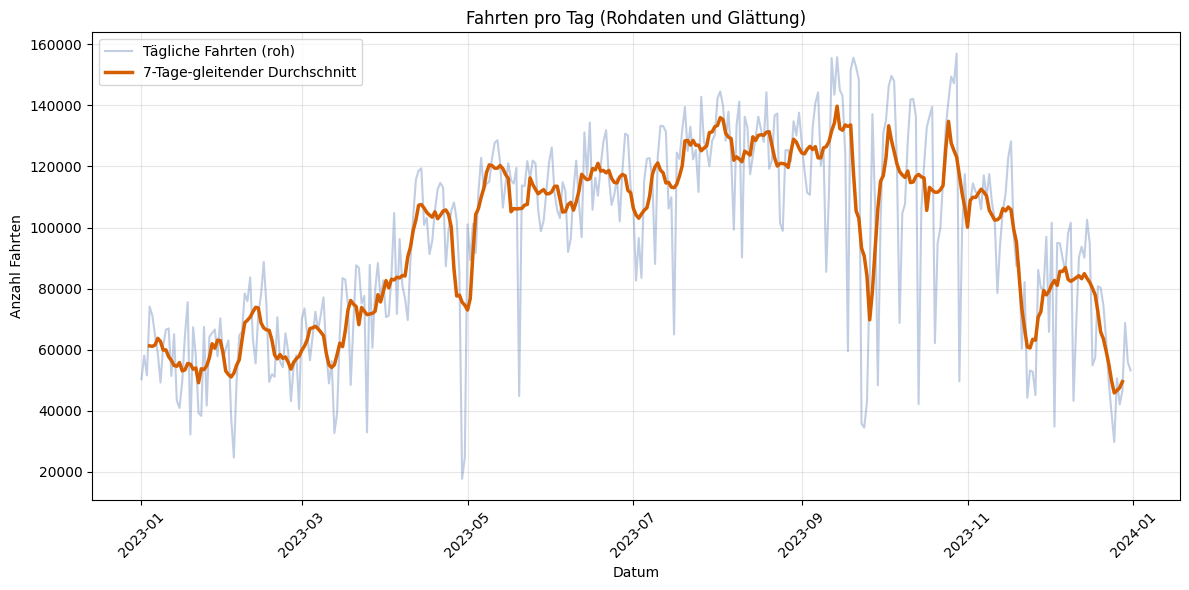

In [38]:
# Berechnung eines 7-Tage-gleitenden Durchschnitts
daily_rides_smoothed = daily_rides.rolling(window=7, center=True).mean()

# Vergleich von Rohdaten und geglätteter Kurve
fig, ax = plt.subplots(figsize=(12, 6))

# Rohwerte
ax.plot(
    daily_rides.index.to_numpy(),
    daily_rides.values,
    color="#4C72B0",
    alpha=0.35,
    label="Tägliche Fahrten (roh)"
)

# Geglättete Werte
ax.plot(
    daily_rides_smoothed.index.to_numpy(),
    daily_rides_smoothed.values,
    color="#D55E00",
    linewidth=2.5,
    label="7-Tage-gleitender Durchschnitt"
)

ax.set_title("Fahrten pro Tag (Rohdaten und Glättung)")
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl Fahrten")
ax.grid(True, alpha=0.3)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()

fig_path = os.path.join(figures_path, "daily_rides_smoothed.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 4.1.3 Verteilung der täglichen Fahrten

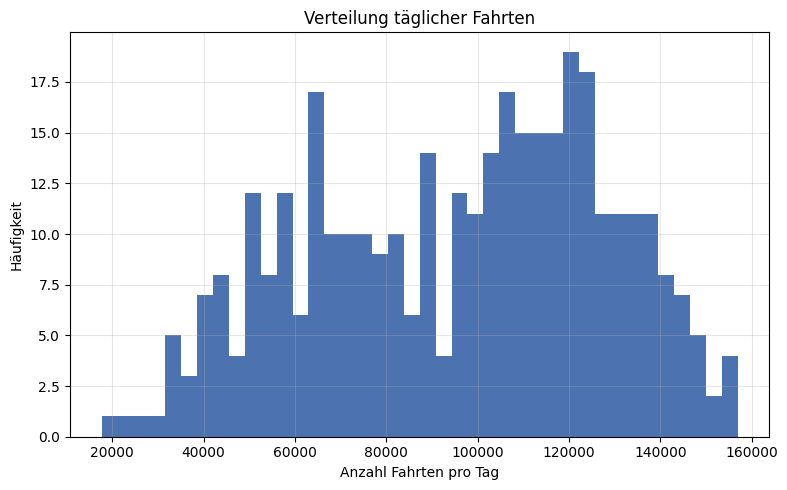

In [37]:
# Histogramm der Verteilung täglicher Fahrten
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(daily_rides.values, bins=40, color="#4C72B0")
ax.set_title("Verteilung täglicher Fahrten")
ax.set_xlabel("Anzahl Fahrten pro Tag")
ax.set_ylabel("Häufigkeit")
ax.grid(alpha=0.3)

plt.tight_layout()

fig_path = os.path.join(figures_path, "daily_rides_distribution.png")
plt.savefig(fig_path, dpi=300)

plt.show()

### 4.2 Monatsmuster

#### 4.2.1 Gesamtfahrten pro Monat

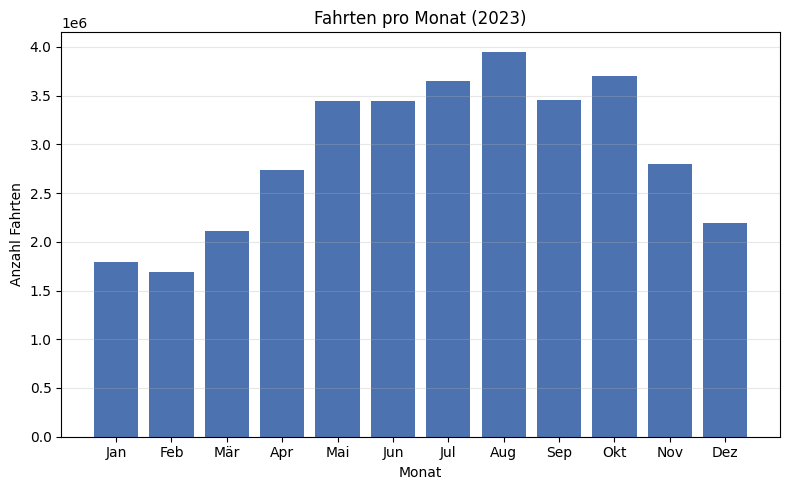

In [36]:
# Aggregation der monatlichen Fahrten
monthly_rides = (
    df_cb_temporal
    .groupby("month", observed=True)
    .size()
    .sort_index()
)

# Balkendiagramm der monatlichen Gesamtfahrten
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(monthly_rides.index, monthly_rides.values, color="#4C72B0")

ax.set_title("Fahrten pro Monat (2023)")
ax.set_xlabel("Monat")
ax.set_ylabel("Anzahl Fahrten")

ax.set_xticks(monthly_rides.index)
ax.set_xticklabels(["Jan","Feb","Mär","Apr","Mai","Jun","Jul","Aug","Sep","Okt","Nov","Dez"])
ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "monthly_rides.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 4.2.2 Median-Dauer pro Monat

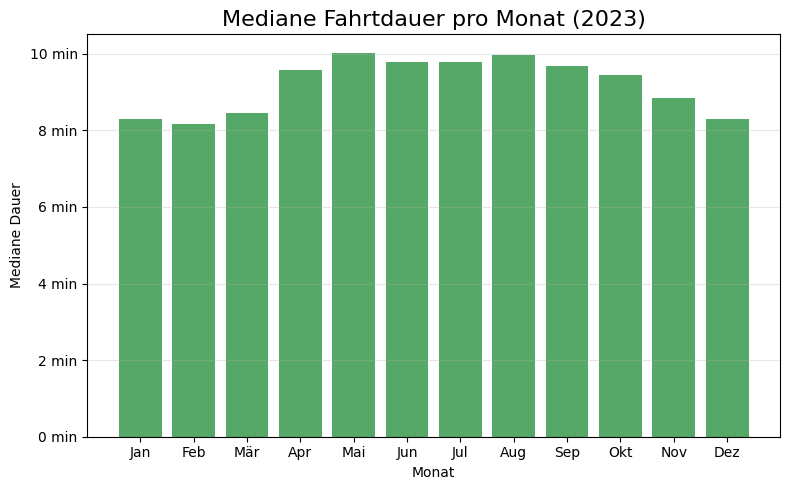

In [35]:
# Berechnung der monatlichen Medianfahrtdauer
monthly_duration = (
    df_cb_temporal
    .groupby("month", observed=True)["duration_min"]
    .median()
    .sort_index()
)

# Balkendiagramm der medianen Fahrtdauer pro Monat
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(monthly_duration.index, monthly_duration.values, color="#55A868")

ax.set_title("Mediane Fahrtdauer pro Monat (2023)", fontsize=16)
ax.set_xlabel("Monat")
ax.set_ylabel("Mediane Dauer")

ax.set_xticks(monthly_duration.index)
ax.set_xticklabels(["Jan","Feb","Mär","Apr","Mai","Jun","Jul","Aug","Sep","Okt","Nov","Dez"])

# Formatierung in HH:MM
ax.yaxis.set_major_formatter(plt.FuncFormatter(minutes_to_hhmm))
ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "monthly_duration_median.png")
plt.savefig(fig_path, dpi=300)

plt.show()

### 4.3 Saisonmuster

#### 4.3.1 Gesamtfahrten pro Saison

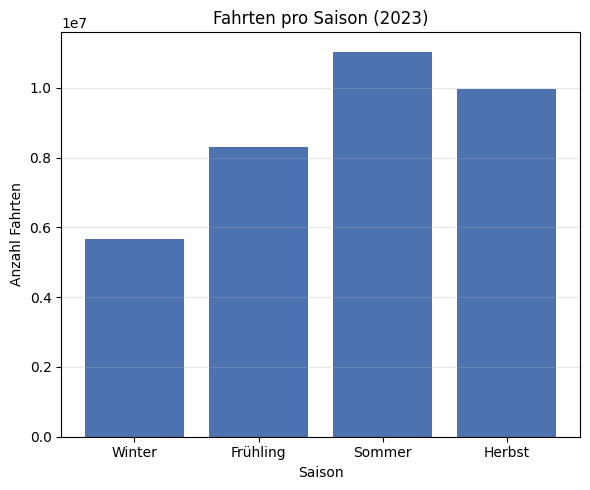

In [33]:
# Saisonreihenfolge für konsistente Darstellung
season_order = ["winter", "spring", "summer", "fall"]

# Aggregation der Fahrten pro Saison
rides_per_season = (
    df_cb_temporal
    .groupby("season", observed=True)
    .size()
    .reindex(season_order)
)

# Deutsche Labels für die Achse
season_labels_de = ["Winter", "Frühling", "Sommer", "Herbst"]

# Balkendiagramm der saisonalen Fahrten
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(rides_per_season.index, rides_per_season.values, color="#4C72B0")

ax.set_title("Fahrten pro Saison (2023)")
ax.set_xlabel("Saison")
ax.set_ylabel("Anzahl Fahrten")

# Deutsche Beschriftungen der Saison
ax.set_xticks(rides_per_season.index)
ax.set_xticklabels(season_labels_de)

ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "seasonal_rides.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 4.3.2 Median-Dauer pro Saison

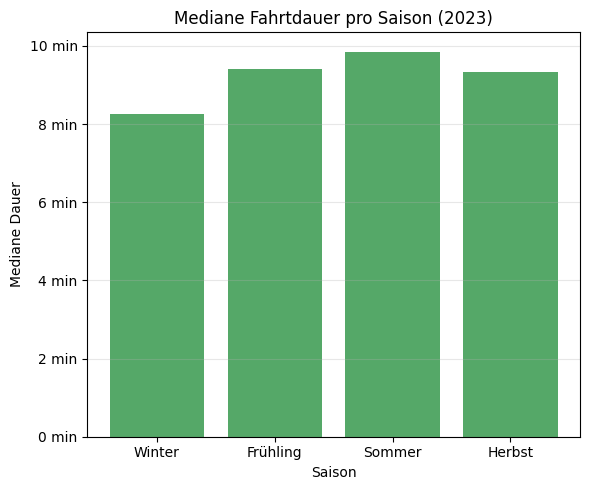

In [41]:
# Saisonreihenfolge für konsistente Darstellung
season_order = ["winter", "spring", "summer", "fall"]

# Berechnung der medianen Fahrtdauer pro Saison
duration_per_season = (
    df_cb_temporal
    .groupby("season", observed=True)["duration_min"]
    .median()
    .reindex(season_order)
)

# Deutsche Labels für die Achse
season_labels_de = ["Winter", "Frühling", "Sommer", "Herbst"]

# Balkendiagramm der medianen saisonalen Fahrtdauer
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(duration_per_season.index, duration_per_season.values, color="#55A868")

ax.set_title("Mediane Fahrtdauer pro Saison (2023)")
ax.set_xlabel("Saison")
ax.set_ylabel("Mediane Dauer")

# Deutsche Beschriftungen der Saison
ax.set_xticks(duration_per_season.index)
ax.set_xticklabels(season_labels_de)

# Formatierung der y-Achse in HH:MM
ax.yaxis.set_major_formatter(plt.FuncFormatter(minutes_to_hhmm))

ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "seasonal_duration_median.png")
plt.savefig(fig_path, dpi=300)

plt.show()

### 4.4 Wochentagsmuster

#### 4.4.1 Fahrten pro Wochentag

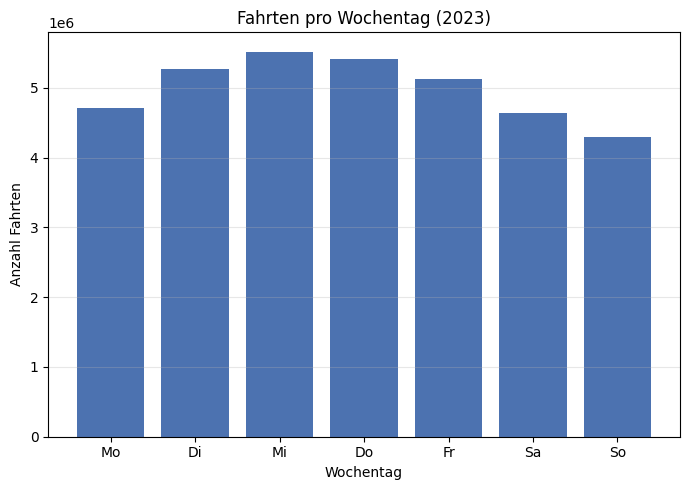

In [45]:
# Reihenfolge und Labels der Wochentage
weekday_order = [0,1,2,3,4,5,6]
weekday_labels_de = ["Mo", "Di", "Mi", "Do", "Fr", "Sa", "So"]

# Aggregation der Fahrten pro Wochentag
rides_per_weekday = (
    df_cb_temporal
    .groupby("weekday", observed=True)
    .size()
    .reindex(weekday_order)
)

# Balkendiagramm der Wochentagsfahrten
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(weekday_labels_de, rides_per_weekday.values, color="#4C72B0")

ax.set_title("Fahrten pro Wochentag (2023)")
ax.set_xlabel("Wochentag")
ax.set_ylabel("Anzahl Fahrten")
ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "weekday_rides.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 4.4.2 Median-Dauer pro Wochentag

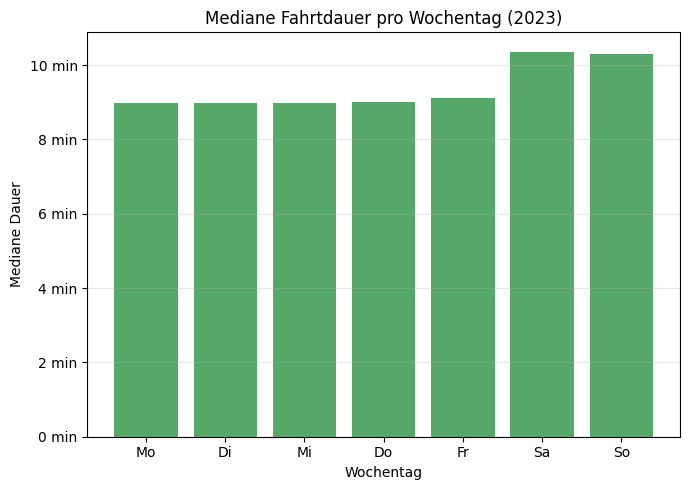

In [46]:
# Berechnung der medianen Fahrtdauer pro Wochentag
duration_per_weekday = (
    df_cb_temporal
    .groupby("weekday", observed=True)["duration_min"]
    .median()
    .reindex(weekday_order)
)

# Balkendiagramm der medianen Fahrtdauer pro Wochentag
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(weekday_labels_de, duration_per_weekday.values, color="#55A868")

ax.set_title("Mediane Fahrtdauer pro Wochentag (2023)")
ax.set_xlabel("Wochentag")
ax.set_ylabel("Mediane Dauer")

# Formatierung der y-Achse in HH:MM
ax.yaxis.set_major_formatter(plt.FuncFormatter(minutes_to_hhmm))

ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "weekday_duration_median.png")
plt.savefig(fig_path, dpi=300)

plt.show()

### 4.5 Tageszeitstruktur

#### 4.5.1 Fahrten pro Stunde

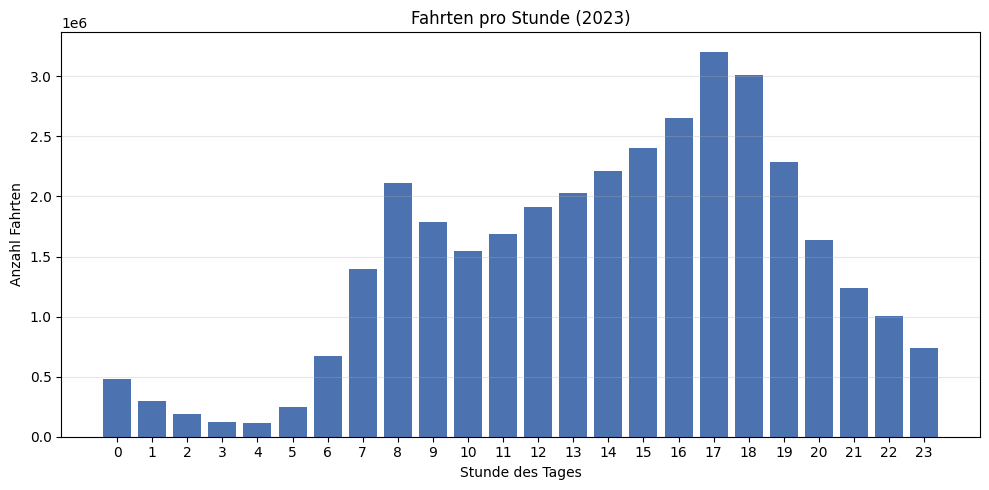

In [49]:
# Reihenfolge der Stundenwerte
hour_order = list(range(24))

# Aggregation der Fahrten pro Stunde
rides_per_hour = (
    df_cb_temporal
    .groupby("hour", observed=True)
    .size()
    .reindex(hour_order)
)

# Balkendiagramm der stündlichen Fahrten
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(hour_order, rides_per_hour.values, color="#4C72B0")

ax.set_title("Fahrten pro Stunde (2023)")
ax.set_xlabel("Stunde des Tages")
ax.set_ylabel("Anzahl Fahrten")

ax.grid(alpha=0.3, axis="y")

plt.xticks(hour_order)
plt.tight_layout()

fig_path = os.path.join(figures_path, "hourly_rides.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 4.5.2 Median-Dauer pro Stunde

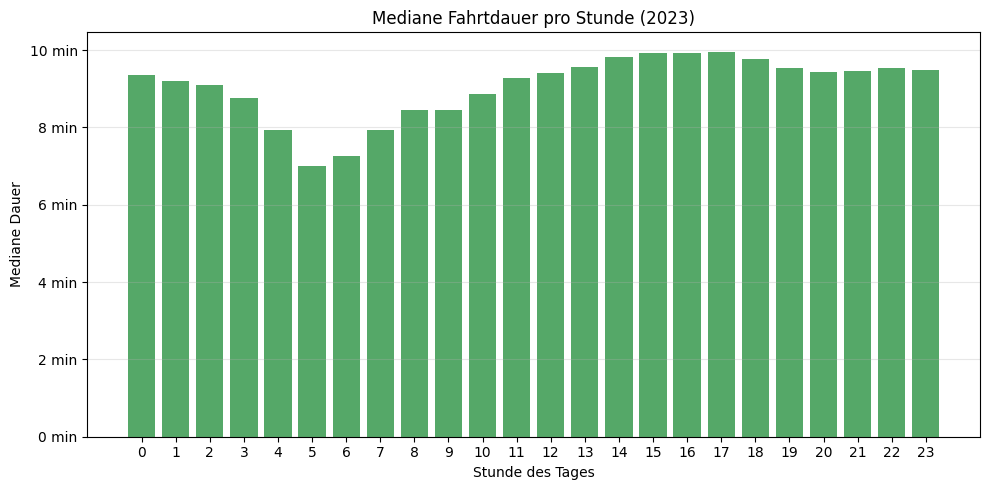

In [50]:
# Berechnung der medianen Fahrtdauer pro Stunde
duration_per_hour = (
    df_cb_temporal
    .groupby("hour", observed=True)["duration_min"]
    .median()
    .reindex(hour_order)
)

# Balkendiagramm der medianen stündlichen Fahrtdauer
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(hour_order, duration_per_hour.values, color="#55A868")

ax.set_title("Mediane Fahrtdauer pro Stunde (2023)")
ax.set_xlabel("Stunde des Tages")
ax.set_ylabel("Mediane Dauer")

ax.yaxis.set_major_formatter(plt.FuncFormatter(minutes_to_hhmm))

ax.grid(alpha=0.3, axis="y")
plt.xticks(hour_order)

plt.tight_layout()

fig_path = os.path.join(figures_path, "hourly_duration_median.png")
plt.savefig(fig_path, dpi=300)

plt.show()

### 4.6 Fahrradtyp-Vergleich (Classic vs. E-Bike)

#### 4.6.1 Monatliche Fahrten nach Fahrradtyp

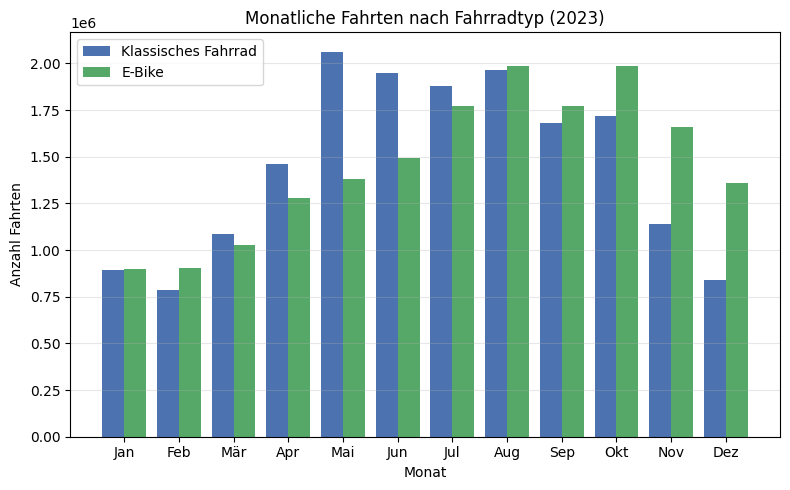

In [52]:
# Aggregation der monatlichen Fahrten nach Fahrradtyp
monthly_rides_split = (
    df_cb_temporal
    .groupby(["month", "rideable_type"], observed=True)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Gestapelter Vergleich der beiden Fahrradtypen
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    monthly_rides_split.index - 0.2,
    monthly_rides_split["classic_bike"].values,
    width=0.4,
    label="Klassisches Fahrrad",
    color="#4C72B0"
)

ax.bar(
    monthly_rides_split.index + 0.2,
    monthly_rides_split["electric_bike"].values,
    width=0.4,
    label="E-Bike",
    color="#55A868"
)

ax.set_title("Monatliche Fahrten nach Fahrradtyp (2023)")
ax.set_xlabel("Monat")
ax.set_ylabel("Anzahl Fahrten")

ax.set_xticks(monthly_rides_split.index)
ax.set_xticklabels(["Jan","Feb","Mär","Apr","Mai","Jun","Jul","Aug","Sep","Okt","Nov","Dez"])

ax.legend()
ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "monthly_rides_by_bike_type.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 4.6.2 Monatliche Median-Dauer nach Fahrradtyp

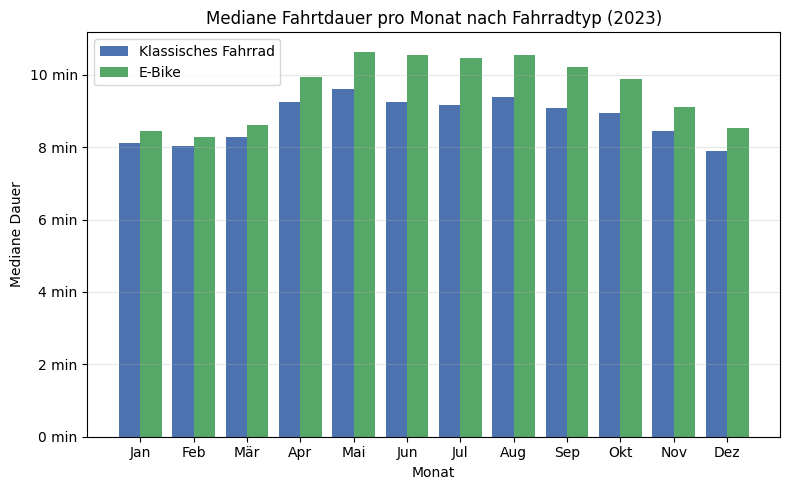

In [53]:
# Berechnung der monatlichen medianen Fahrtdauer je Fahrradtyp
monthly_duration_split = (
    df_cb_temporal
    .groupby(["month", "rideable_type"], observed=True)["duration_min"]
    .median()
    .unstack(fill_value=0)
    .sort_index()
)

# Balkendiagramm der medianen Fahrtdauer pro Monat und Fahrradtyp
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    monthly_duration_split.index - 0.2,
    monthly_duration_split["classic_bike"].values,
    width=0.4,
    label="Klassisches Fahrrad",
    color="#4C72B0"
)

ax.bar(
    monthly_duration_split.index + 0.2,
    monthly_duration_split["electric_bike"].values,
    width=0.4,
    label="E-Bike",
    color="#55A868"
)

ax.set_title("Mediane Fahrtdauer pro Monat nach Fahrradtyp (2023)")
ax.set_xlabel("Monat")
ax.set_ylabel("Mediane Dauer")

ax.set_xticks(monthly_duration_split.index)
ax.set_xticklabels(["Jan","Feb","Mär","Apr","Mai","Jun","Jul","Aug","Sep","Okt","Nov","Dez"])

# Formatierung in HH:MM
ax.yaxis.set_major_formatter(plt.FuncFormatter(minutes_to_hhmm))

ax.legend()
ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "monthly_duration_by_bike_type.png")
plt.savefig(fig_path, dpi=300)

plt.show()

## 5. Zeitliche Muster NYPD

In diesem Abschnitt werden die zeitlichen Strukturen der gemeldeten Verkehrsunfälle analysiert. 
Betrachtet werden tägliche, monatliche, wöchentliche und stündliche Muster sowie Unterschiede zwischen allgemeinen Unfällen und Fahrradbeteiligungen.

### 5.1 Tagesmuster

#### 5.1.1 Verteilung der täglichen Unfallzahlen (alle Unfälle)

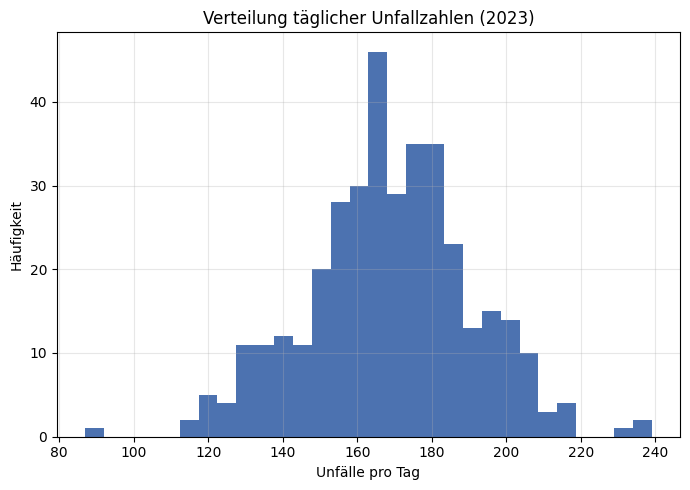

In [56]:
# Aggregation der täglichen Unfallzahlen
daily_crashes = (
    df_nypd_temporal
    .groupby("date", observed=True)
    .size()
    .sort_index()
)

# Histogramm der täglichen Unfallzahlen
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(daily_crashes.values, bins=30, color="#4C72B0")

ax.set_title("Verteilung täglicher Unfallzahlen (2023)")
ax.set_xlabel("Unfälle pro Tag")
ax.set_ylabel("Häufigkeit")

ax.grid(alpha=0.3)

plt.tight_layout()

fig_path = os.path.join(figures_path, "daily_crashes_distribution.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 5.1.2 Verteilung der täglichen Fahrradunfälle

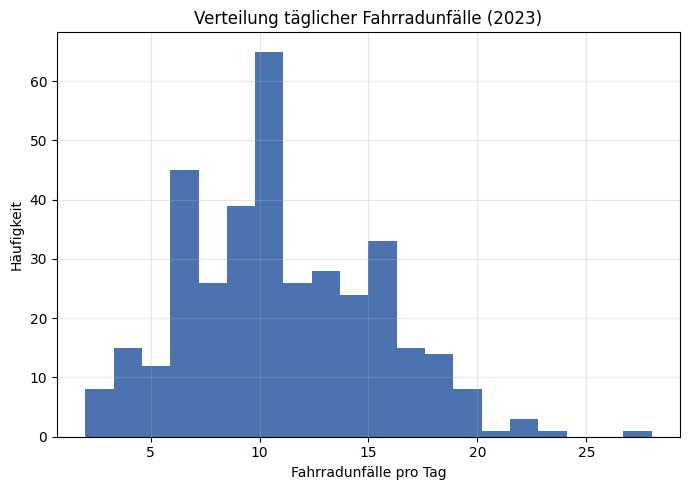

In [57]:
# Filter und Aggregation der täglichen Fahrradunfälle
daily_crashes_cyclist = (
    df_nypd_temporal[df_nypd_temporal["cyclist_involved"] == True]
    .groupby("date", observed=True)
    .size()
    .sort_index()
)

# Histogramm der täglichen Fahrradunfälle
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(daily_crashes_cyclist.values, bins=20, color="#4C72B0")

ax.set_title("Verteilung täglicher Fahrradunfälle (2023)")
ax.set_xlabel("Fahrradunfälle pro Tag")
ax.set_ylabel("Häufigkeit")

ax.grid(alpha=0.3)

plt.tight_layout()

fig_path = os.path.join(figures_path, "daily_cyclist_crashes_distribution.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 5.1.3 Tägliche Unfallzahlen (Zeitreihe)

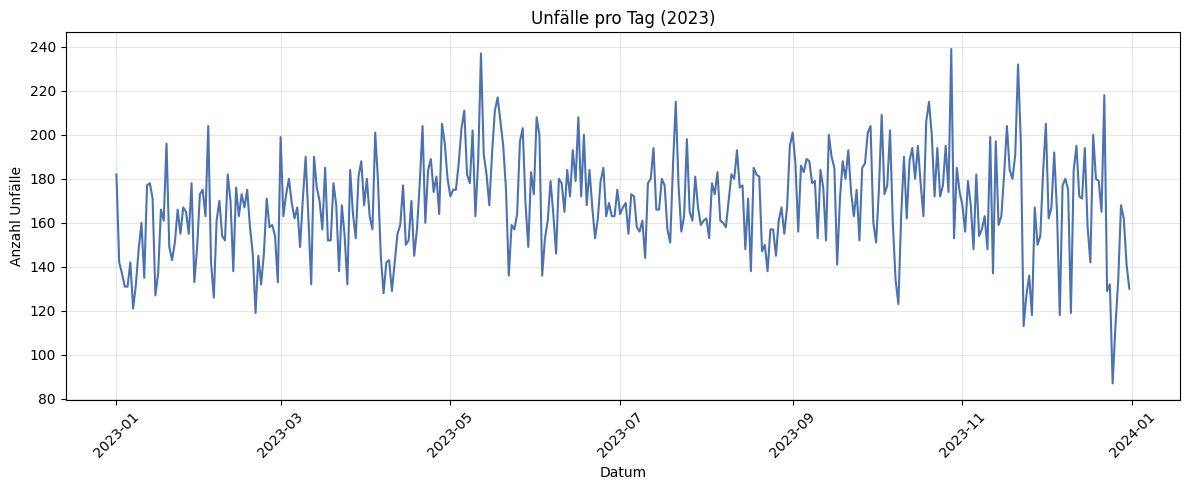

In [60]:
# Zeitreihe der täglichen Unfallzahlen
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(
    daily_crashes.index.to_numpy(),
    daily_crashes.values,
    color="#4C72B0"
)

ax.set_title("Unfälle pro Tag (2023)")
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl Unfälle")

ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)

plt.tight_layout()

fig_path = os.path.join(figures_path, "daily_crashes_timeseries.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 5.1.4 7-Tage-gleitender Durchschnitt (alle Unfälle)

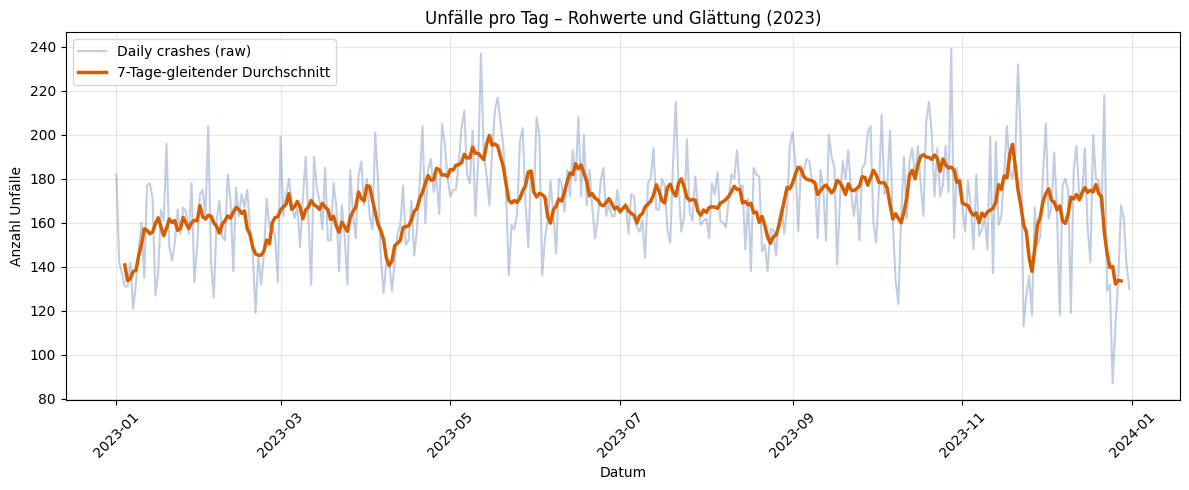

In [63]:
# Berechnung eines 7-Tage-gleitenden Durchschnitts
daily_crashes_smoothed = daily_crashes.rolling(window=7, center=True).mean()

# Vergleich von Rohdaten und Glättung
fig, ax = plt.subplots(figsize=(12, 5))

# Rohwerte
ax.plot(
    daily_crashes.index.to_numpy(),
    daily_crashes.values,
    color="#4C72B0",
    alpha=0.35,
    label="Daily crashes (raw)"
)

# Glättung
ax.plot(
    daily_crashes_smoothed.index.to_numpy(),
    daily_crashes_smoothed.values,
    color="#D55E00",
    linewidth=2.5,
    label="7-Tage-gleitender Durchschnitt"
)

ax.set_title("Unfälle pro Tag – Rohwerte und Glättung (2023)")
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl Unfälle")

ax.grid(True, alpha=0.3)

ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

fig_path = os.path.join(figures_path, "daily_crashes_smoothed.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 5.1.5 Tägliche Fahrradunfälle (Zeitreihe)

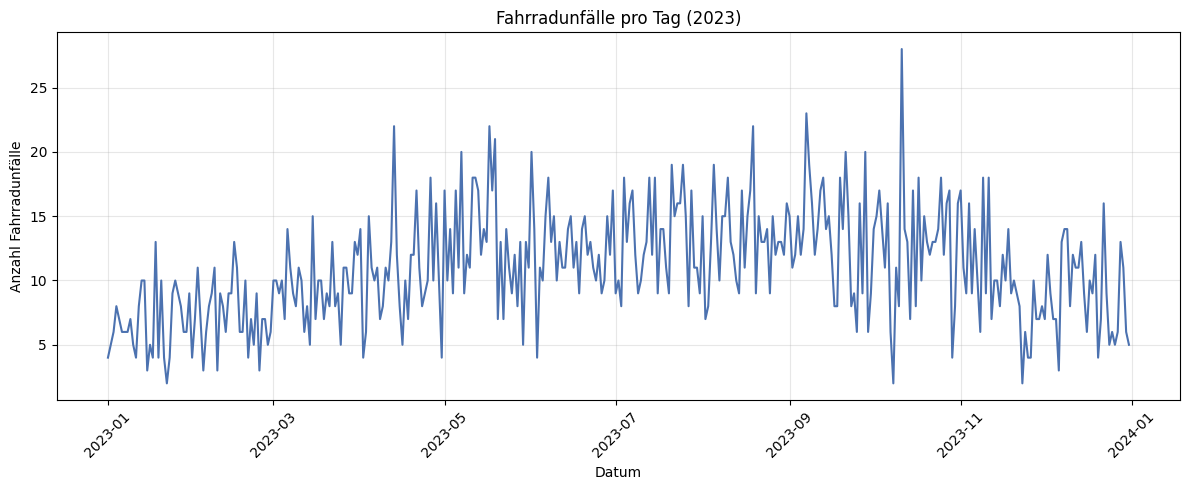

In [65]:
# Zeitreihe der täglichen Fahrradunfälle
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(
    daily_crashes_cyclist.index.to_numpy(),
    daily_crashes_cyclist.values,
    color="#4C72B0"
)

ax.set_title("Fahrradunfälle pro Tag (2023)")
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl Fahrradunfälle")

ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()

fig_path = os.path.join(figures_path, "daily_cyclist_crashes_timeseries.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 5.1.6 7-Tage-gleitender Durchschnitt (Fahrradunfälle)

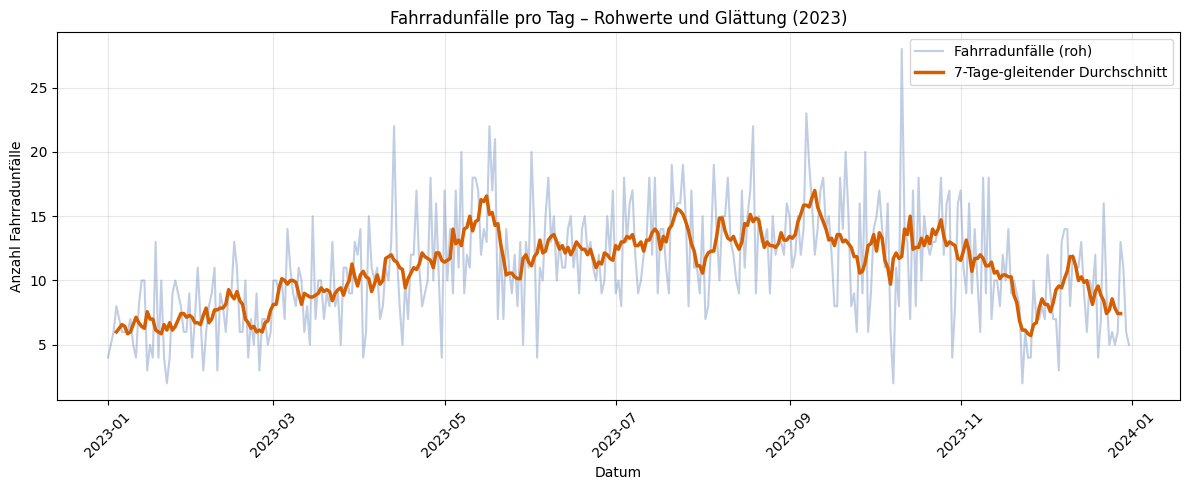

In [66]:
# Berechnung eines 7-Tage-gleitenden Durchschnitts für Fahrradunfälle
daily_crashes_cyclist_smoothed = daily_crashes_cyclist.rolling(window=7, center=True).mean()

# Vergleich Rohwerte / Glättung
fig, ax = plt.subplots(figsize=(12, 5))

# Rohwerte
ax.plot(
    daily_crashes_cyclist.index.to_numpy(),
    daily_crashes_cyclist.values,
    color="#4C72B0",
    alpha=0.35,
    label="Fahrradunfälle (roh)"
)

# Glättung
ax.plot(
    daily_crashes_cyclist_smoothed.index.to_numpy(),
    daily_crashes_cyclist_smoothed.values,
    color="#D55E00",
    linewidth=2.5,
    label="7-Tage-gleitender Durchschnitt"
)

ax.set_title("Fahrradunfälle pro Tag – Rohwerte und Glättung (2023)")
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl Fahrradunfälle")

ax.grid(True, alpha=0.3)

ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

fig_path = os.path.join(figures_path, "daily_cyclist_crashes_smoothed.png")
plt.savefig(fig_path, dpi=300)

plt.show()

### 5.2 Monatsmuster

#### 5.2.1 Unfallzahlen pro Monat (alle Unfälle)

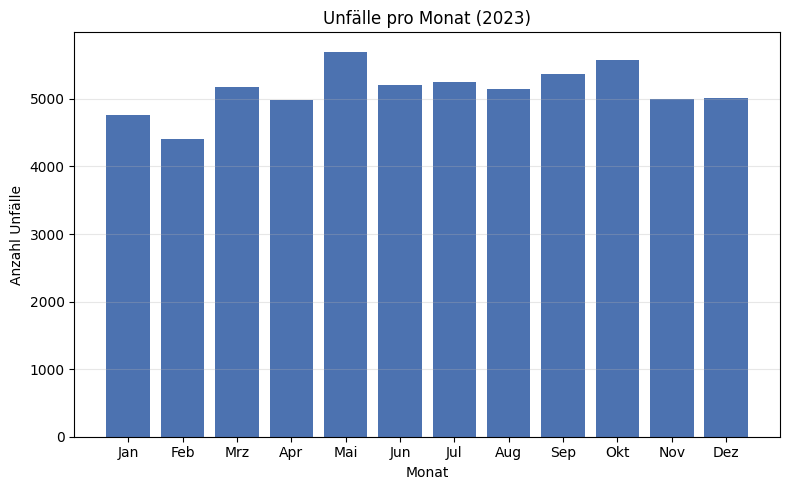

In [68]:
# Aggregation der monatlichen Unfallzahlen (alle Unfälle)
monthly_crashes = (
    df_nypd_temporal
    .groupby("month", observed=True)
    .size()
    .sort_index()
)

# Balkendiagramm der monatlichen Unfallzahlen
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(monthly_crashes.index, monthly_crashes.values, color="#4C72B0")

ax.set_title("Unfälle pro Monat (2023)")
ax.set_xlabel("Monat")
ax.set_ylabel("Anzahl Unfälle")

ax.set_xticks(monthly_crashes.index)
ax.set_xticklabels(["Jan","Feb","Mrz","Apr","Mai","Jun","Jul","Aug","Sep","Okt","Nov","Dez"])

ax.grid(alpha=0.3, axis="y")
plt.tight_layout()

fig_path = os.path.join(figures_path, "monthly_crashes.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 5.2.2 Unfallzahlen pro Monat (Fahrradunfälle)

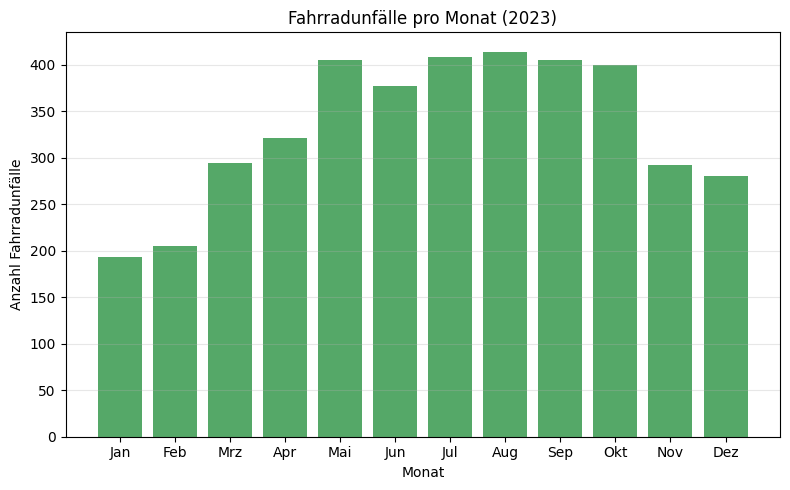

In [69]:
# Aggregation der monatlichen Fahrradunfälle
monthly_crashes_cyclist = (
    df_nypd_temporal[df_nypd_temporal["cyclist_involved"] == True]
    .groupby("month", observed=True)
    .size()
    .sort_index()
)

# Balkendiagramm der monatlichen Fahrradunfälle
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(monthly_crashes_cyclist.index, monthly_crashes_cyclist.values, color="#55A868")

ax.set_title("Fahrradunfälle pro Monat (2023)")
ax.set_xlabel("Monat")
ax.set_ylabel("Anzahl Fahrradunfälle")

ax.set_xticks(monthly_crashes_cyclist.index)
ax.set_xticklabels(["Jan","Feb","Mrz","Apr","Mai","Jun","Jul","Aug","Sep","Okt","Nov","Dez"])

ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "monthly_cyclist_crashes.png")
plt.savefig(fig_path, dpi=300)

plt.show()

### 5.3 Wochenstruktur

#### 5.3.1 Unfälle pro Wochentag (alle Unfälle)

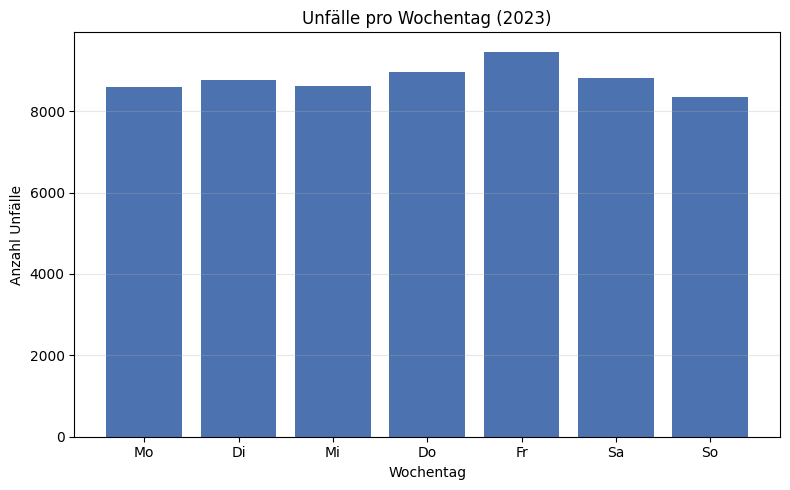

In [84]:
# Aggregation der Wochentagsunfälle (alle Unfälle)
weekday_crashes = (
    df_nypd_temporal
    .groupby("weekday", observed=True)
    .size()
    .reindex([0,1,2,3,4,5,6])  # Mo–So in richtiger Reihenfolge
)

weekday_labels = ["Mo", "Di", "Mi", "Do", "Fr", "Sa", "So"]

# Balkendiagramm der Unfälle pro Wochentag
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(weekday_labels, weekday_crashes.values, color="#4C72B0")

ax.set_title("Unfälle pro Wochentag (2023)")
ax.set_xlabel("Wochentag")
ax.set_ylabel("Anzahl Unfälle")
ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "weekday_crashes.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 5.3.2 Unfälle pro Wochentag (Fahrradunfälle)

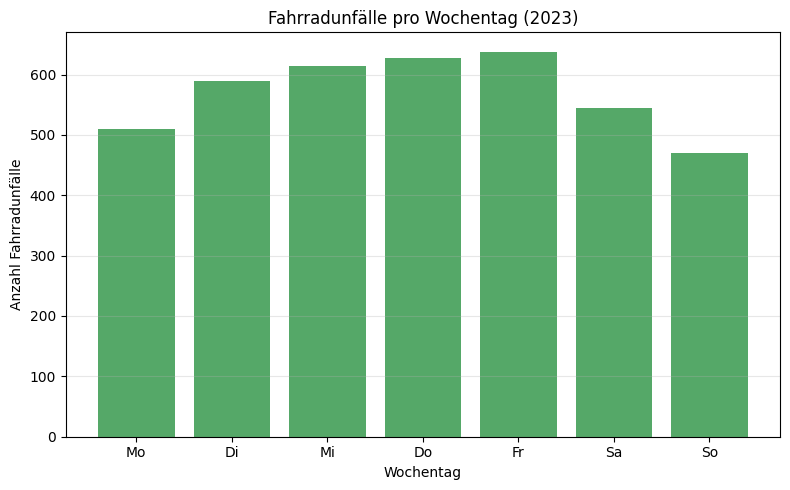

In [85]:
# Aggregation der Fahrradunfälle pro Wochentag
weekday_crashes_cyclist = (
    df_nypd_temporal[df_nypd_temporal["cyclist_involved"] == True]
    .groupby("weekday", observed=True)
    .size()
    .reindex([0,1,2,3,4,5,6])
)

# Balkendiagramm der Fahrradunfälle pro Wochentag
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(weekday_labels, weekday_crashes_cyclist.values, color="#55A868")

ax.set_title("Fahrradunfälle pro Wochentag (2023)")
ax.set_xlabel("Wochentag")
ax.set_ylabel("Anzahl Fahrradunfälle")
ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "weekday_cyclist_crashes.png")
plt.savefig(fig_path, dpi=300)

plt.show()

### 5.4 Tageszeitstruktur

#### 5.4.1 Unfälle pro Stunde (alle Unfälle)

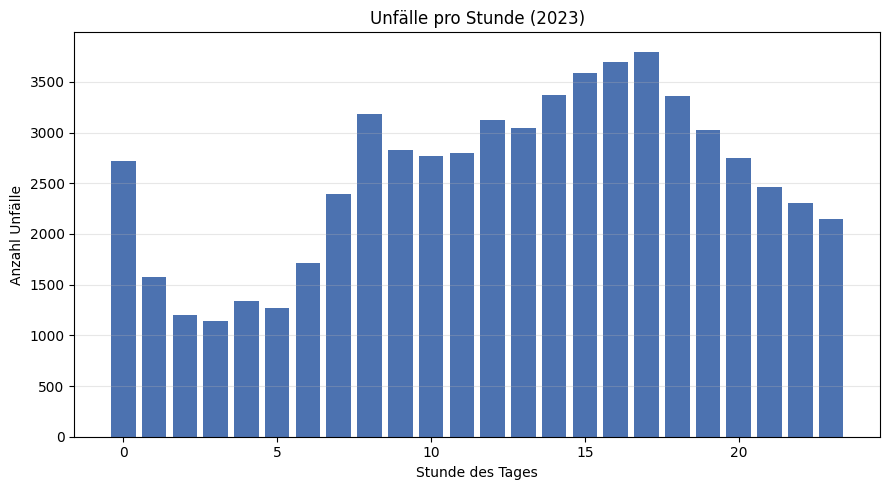

In [86]:
# Aggregation der stündlichen Unfälle
hourly_crashes = (
    df_nypd_temporal
    .groupby("hour", observed=True)
    .size()
    .reindex(range(24))  # 0–23 Uhr
)

# Balkendiagramm der Unfälle pro Stunde
fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(hourly_crashes.index, hourly_crashes.values, color="#4C72B0")

ax.set_title("Unfälle pro Stunde (2023)")
ax.set_xlabel("Stunde des Tages")
ax.set_ylabel("Anzahl Unfälle")
ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "hourly_crashes.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 5.4.2 Unfälle pro Stunde (Fahrradunfälle)

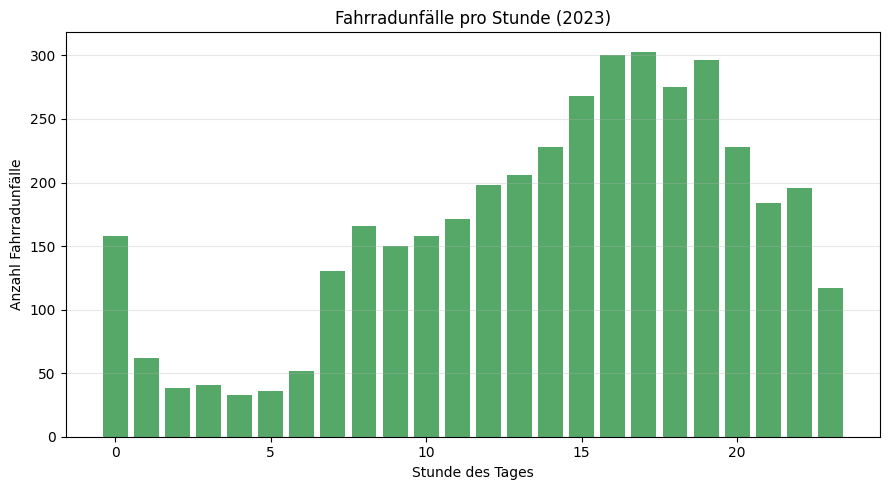

In [87]:
# Aggregation der stündlichen Fahrradunfälle
hourly_crashes_cyclist = (
    df_nypd_temporal[df_nypd_temporal["cyclist_involved"] == True]
    .groupby("hour", observed=True)
    .size()
    .reindex(range(24))
)

# Balkendiagramm der stündlichen Fahrradunfälle
fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(hourly_crashes_cyclist.index, hourly_crashes_cyclist.values, color="#55A868")

ax.set_title("Fahrradunfälle pro Stunde (2023)")
ax.set_xlabel("Stunde des Tages")
ax.set_ylabel("Anzahl Fahrradunfälle")
ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "hourly_cyclist_crashes.png")
plt.savefig(fig_path, dpi=300)

plt.show()

### 5.5 Vergleich: Fahrrad vs. E-Bike

#### 5.5.1 Monatliche Unfallzahlen: Fahrrad vs. E-Bike

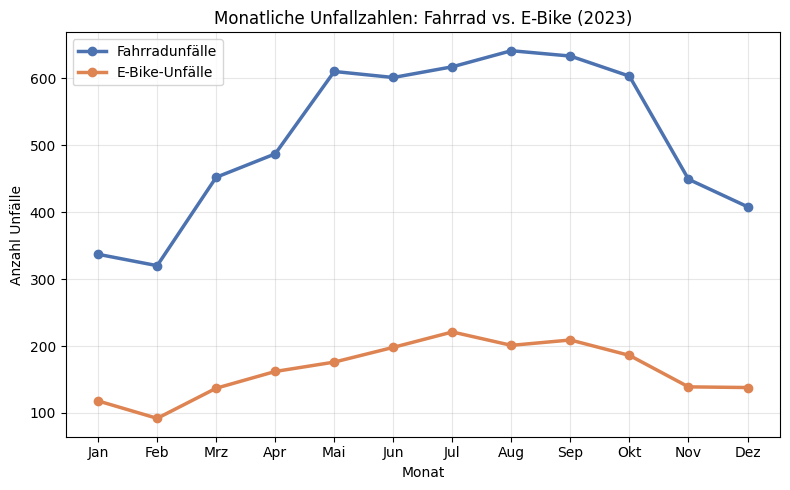

In [88]:
# Monatliche Unfälle: klassische Fahrräder
monthly_bike = (
    df_nypd_temporal[df_nypd_temporal["bike_involved"] == True]
    .groupby("month", observed=True)
    .size()
    .reindex(range(1,13))
)

# Monatliche Unfälle: E-Bikes
monthly_ebike = (
    df_nypd_temporal[df_nypd_temporal["ebike_involved"] == True]
    .groupby("month", observed=True)
    .size()
    .reindex(range(1,13))
)

monats_labels = ["Jan","Feb","Mrz","Apr","Mai","Jun","Jul","Aug","Sep","Okt","Nov","Dez"]

# Liniendiagramm Monatsunfälle
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(
    monthly_bike.index.to_numpy(),
    monthly_bike.values,
    marker="o", linewidth=2.5,
    color="#4C72B0",
    label="Fahrradunfälle"
)

ax.plot(
    monthly_ebike.index.to_numpy(),
    monthly_ebike.values,
    marker="o", linewidth=2.5,
    color="#DD8452",
    label="E-Bike-Unfälle"
)

ax.set_title("Monatliche Unfallzahlen: Fahrrad vs. E-Bike (2023)")
ax.set_xlabel("Monat")
ax.set_ylabel("Anzahl Unfälle")

ax.set_xticks(monthly_bike.index.to_numpy())
ax.set_xticklabels(monats_labels)

ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()

fig_path = os.path.join(figures_path, "monthly_bike_vs_ebike_crashes.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 5.5.2 Stündliche Unfallzahlen: Fahrrad vs. E-Bike

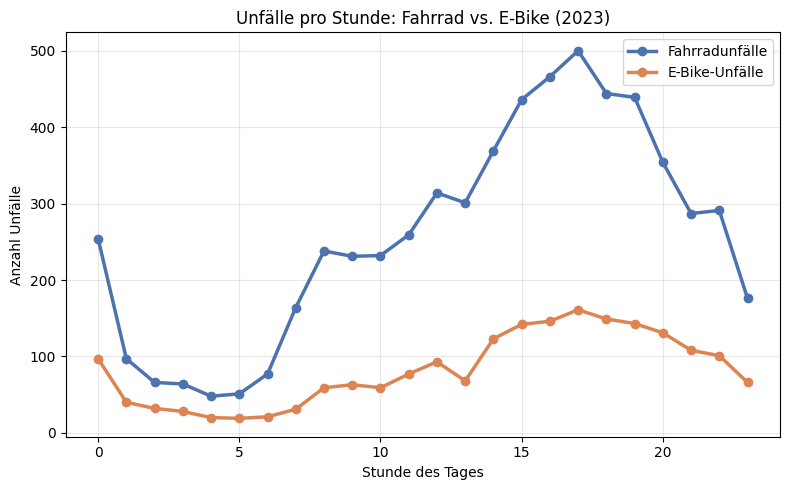

In [89]:
# Stündliche Unfälle: klassische Fahrräder
hourly_bike = (
    df_nypd_temporal[df_nypd_temporal["bike_involved"] == True]
    .groupby("hour", observed=True)
    .size()
    .reindex(range(24))
)

# Stündliche Unfälle: E-Bikes
hourly_ebike = (
    df_nypd_temporal[df_nypd_temporal["ebike_involved"] == True]
    .groupby("hour", observed=True)
    .size()
    .reindex(range(24))
)

# Liniendiagramm stündliche Unfälle
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(hourly_bike.index.to_numpy(), hourly_bike.values,
        color="#4C72B0", linewidth=2.5, marker="o", label="Fahrradunfälle")

ax.plot(hourly_ebike.index.to_numpy(), hourly_ebike.values,
        color="#DD8452", linewidth=2.5, marker="o", label="E-Bike-Unfälle")

ax.set_title("Unfälle pro Stunde: Fahrrad vs. E-Bike (2023)")
ax.set_xlabel("Stunde des Tages")
ax.set_ylabel("Anzahl Unfälle")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()

fig_path = os.path.join(figures_path, "hourly_bike_vs_ebike_crashes.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 5.5.3 Schwere Unfälle pro Stunde: Fahrrad vs. E-Bike

Dieser Schritt dient der Prüfung, ob ausreichende Fallzahlen für eine getrennte Betrachtung schwerer Unfälle nach Fahrrad- und E-Bike-Beteiligung vorliegen.

In [90]:
# Anzahl verletzter Radfahrer ermitteln
classic_severe_n = df_nypd_temporal["NUMBER OF CYCLIST INJURED"].sum()
# Anzahl getöteter E-Bike-Fahrer (bzw. schwerer Fälle, falls separat gezählt)
ebike_severe_n   = df_nypd_temporal["NUMBER OF CYCLIST KILLED"].sum()  # optional

# Ausgabe der Stichprobengrößen
print("Stichprobengröße (verletzte Radfahrer):", classic_severe_n)
print("Stichprobengröße (getötete E-Bike-Fahrer):", ebike_severe_n)

Stichprobengröße (verletzte Radfahrer): 4028
Stichprobengröße (getötete E-Bike-Fahrer): 22


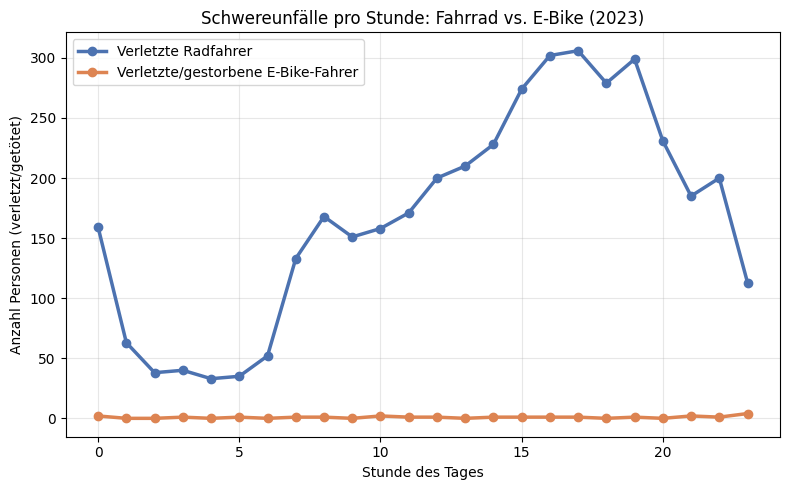

In [91]:
# Aggregation der stündlichen Verletztenzahlen für Fahrrad
hourly_bike_severe = (
    df_nypd_temporal
    .groupby("hour", observed=True)["NUMBER OF CYCLIST INJURED"]
    .sum()
    .reindex(range(24))
)

# Aggregation der stündlichen Verletztenzahlen für E-Bikes
hourly_ebike_severe = (
    df_nypd_temporal
    .groupby("hour", observed=True)["NUMBER OF CYCLIST KILLED"]  # falls separat gezählt
    .sum()
    .reindex(range(24))
)

# Liniendiagramm schwere Verletzungen
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(hourly_bike_severe.index.to_numpy(), hourly_bike_severe.values,
        linewidth=2.5, color="#4C72B0", marker="o", label="Verletzte Radfahrer")

ax.plot(hourly_ebike_severe.index.to_numpy(), hourly_ebike_severe.values,
        linewidth=2.5, color="#DD8452", marker="o", label="Verletzte/gestorbene E-Bike-Fahrer")

ax.set_title("Schwereunfälle pro Stunde: Fahrrad vs. E-Bike (2023)")
ax.set_xlabel("Stunde des Tages")
ax.set_ylabel("Anzahl Personen (verletzt/getötet)")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()

fig_path = os.path.join(figures_path, "hourly_severe_bike_vs_ebike.png")
plt.savefig(fig_path, dpi=300)

plt.show()

## 6. Gemeinsame zeitliche Analyse (CitiBike × NYPD)

In diesem Abschnitt werden die zeitlichen Muster der CitiBike-Nutzung und der NYPD-Fahrradunfälle zusammengeführt. 
Ziel ist eine erste risikoorientierte Betrachtung, bei der Fahrten (Exposure) und Unfälle im zeitlichen Verlauf gegenübergestellt werden. 
Zusätzlich wird ein risikobasierter Quotient berechnet, der Unfallhäufigkeiten relativ zur Nutzung abbildet.

### 6.1 Risiko pro Stunde: Fahrten vs. Unfälle

#### 6.1.1 Fahrten, Unfälle und Risiko pro Stunde

In [92]:
# Fahrten pro Stunde (Exposure)
rides_hour = (
    df_cb_temporal
    .groupby("hour", observed=True)
    .size()
    .reindex(range(24))
)

# Fahrradunfälle pro Stunde
crashes_hour = (
    df_nypd_temporal[df_nypd_temporal["cyclist_involved"] == True]
    .groupby("hour", observed=True)
    .size()
    .reindex(range(24))
)


# Risiko pro Stunde (Unfälle relativ zur Nutzung)
risk_hour = crashes_hour / rides_hour

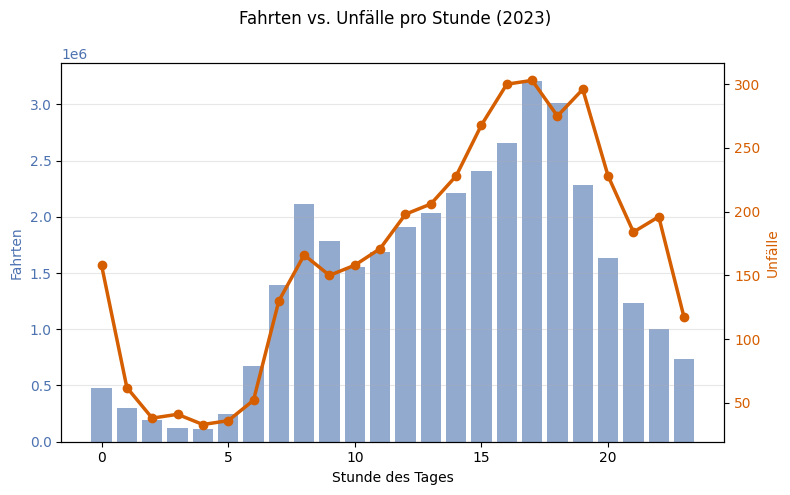

In [93]:
# Vergleich von Fahrten und Unfällen pro Stunde
fig, ax1 = plt.subplots(figsize=(8, 5))

# Fahrten (linke Achse)
ax1.bar(
    rides_hour.index.to_numpy(),
    rides_hour.values,
    alpha=0.6,
    color="#4C72B0",
    label="Fahrten (CitiBike)"
)

ax1.set_xlabel("Stunde des Tages")
ax1.set_ylabel("Fahrten", color="#4C72B0")
ax1.tick_params(axis="y", labelcolor="#4C72B0")
ax1.grid(alpha=0.3, axis="y")

# Unfälle (rechte Achse)
ax2 = ax1.twinx()

ax2.plot(
    crashes_hour.index.to_numpy(),
    crashes_hour.values,
    color="#D55E00",
    linewidth=2.5,
    marker="o",
    label="Unfälle (NYPD)"
)

ax2.set_ylabel("Unfälle", color="#D55E00")
ax2.tick_params(axis="y", labelcolor="#D55E00")

fig.suptitle("Fahrten vs. Unfälle pro Stunde (2023)")

plt.tight_layout()

fig_path = os.path.join(figures_path, "hourly_rides_vs_crashes.png")
plt.savefig(fig_path, dpi=300)

plt.show()

#### 6.1.2 Risiko pro Stunde

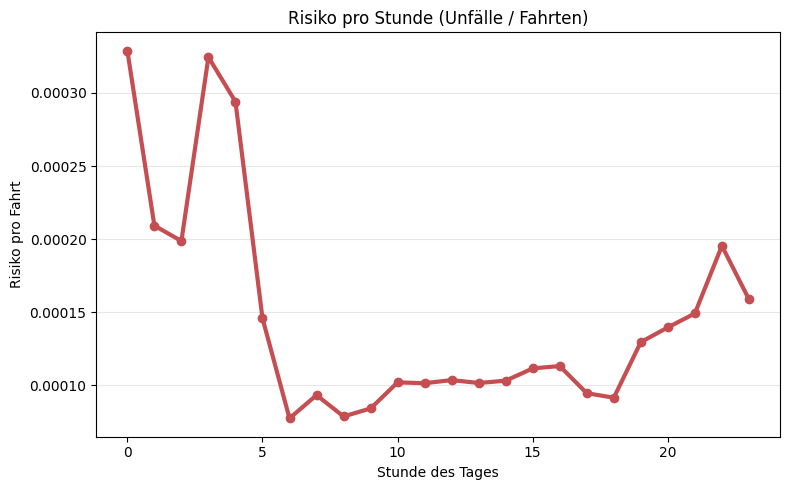

In [94]:
# Liniendiagramm des Risikos pro Stunde
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(
    risk_hour.index.to_numpy(),
    risk_hour.values,
    color="#C44E52",
    linewidth=3,
    marker="o"
)

ax.set_title("Risiko pro Stunde (Unfälle / Fahrten)")
ax.set_xlabel("Stunde des Tages")
ax.set_ylabel("Risiko pro Fahrt")
ax.grid(alpha=0.3, axis="y")

plt.tight_layout()

fig_path = os.path.join(figures_path, "hourly_risk.png")
plt.savefig(fig_path, dpi=300)

plt.show()

### 6.2 Risiko nach Wochentag und Stunde

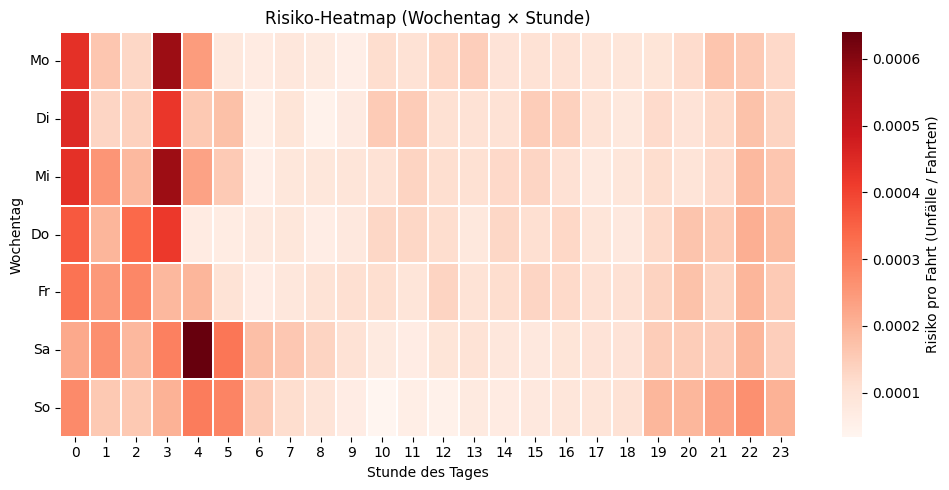

In [95]:
# Fahrten pro Wochentag und Stunde
rides_wh = (
    df_cb_temporal
    .groupby(["weekday", "hour"], observed=True)
    .size()
    .unstack(fill_value=0)
    .reindex(index=[0,1,2,3,4,5,6], columns=range(24))  # Mo–So, 0–23 Uhr
)

# Fahrradunfälle pro Wochentag und Stunde
crashes_wh = (
    df_nypd_temporal[df_nypd_temporal["cyclist_involved"] == True]
    .groupby(["weekday", "hour"], observed=True)
    .size()
    .unstack(fill_value=0)
    .reindex(index=[0,1,2,3,4,5,6], columns=range(24))
)

# Risiko-Matrix (NaN, wenn keine Fahrten)
risk_wh = crashes_wh / rides_wh   # division ergibt NaN bei zero-exposure

# Heatmap des stündlichen Risikos nach Wochentag
fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(
    risk_wh,
    cmap="Reds",
    linewidths=0.3,
    linecolor="white",
    ax=ax,
    cbar_kws={"label": "Risiko pro Fahrt (Unfälle / Fahrten)"}
)

ax.set_title("Risiko-Heatmap (Wochentag × Stunde)")
ax.set_xlabel("Stunde des Tages")
ax.set_ylabel("Wochentag")

ax.set_yticklabels(["Mo","Di","Mi","Do","Fr","Sa","So"], rotation=0)

plt.tight_layout()

fig_path = os.path.join(figures_path, "risk_heatmap_weekday_hour.png")
plt.savefig(fig_path, dpi=300)

plt.show()

### 6.3 Speichern der temporalen Datensätze

Zum Abschluss werden die erweiterten temporalen Datensätze für CitiBike und NYPD im Projektverzeichnis gespeichert.

In [96]:
# Zielpfade für die zeitlichen Datensätze
cb_temporal_path = os.path.join(DATA_TEMPORAL, "citibike_temporal.parquet")
nypd_temporal_path = os.path.join(DATA_TEMPORAL, "nypd_temporal.parquet")

# Speichern der temporalen Datensätze
df_cb_temporal.to_parquet(cb_temporal_path, index=False)
df_nypd_temporal.to_parquet(nypd_temporal_path, index=False)

print("Zeitliche Datensätze gespeichert.")

Zeitliche Datensätze gespeichert.
